# Battle of the Neighborhoods - Washington DC Tour Guides

## 1. Introducton: Business Problem
##### With the hope that COVID 19 restrictions will be lifted by the spring, there's an opportunity for a lot of travel, and tourism income for large cities and businesses. Washington DC hopes to see a lot of this travel and wants to set up a series of tours for tourists. The goal of this project is to segment neighborhoods in Washington DC by venues in an attempt to plan out a full Washington DC tour capturing the essence of the city.

## 2. Data
#### 2.1 Data Sources
##### The data used for this study will be:
##### 1. Dataset of Washington D.C. neighborhoods from Open Data DC, which has been prepared as a CSV file and imported (https://opendata.dc.gov/datasets/neighborhood-labels/data).
##### 2. Venue data pertaining to DC (via Foursquare). The Venue data will be used to segment Washington DC into clusters to be used for tour groups and city tourism.
#### 2.2 Data Wrangling
##### The first step is to use pandas to get the D.C. Neighborhoods dataset from Open Data DC.

In [1]:
# import environment
!pip install lxml

import pandas as pd
import requests
import numpy as np

In [2]:
#set url variable
DC_url =  "https://opendata.arcgis.com/datasets/c4b0cd43d50949e98e57de9f22b455fc_35.csv"

In [3]:
#using csv file of Washington DC Neighborhoods
df_DC = pd.read_csv(DC_url)
df_DC.head()

,X,Y,OBJECTID,GIS_ID,NAME,WEB_URL,LABEL_NAME,DATELASTMODIFIED
0,-76.980348,38.855658,1,nhood_050,Fort Stanton,http://NeighborhoodAction.dc.gov,Fort Stanton,2003/04/10 00:00:00+00
1,-76.997950,38.841077,2,nhood_031,Congress Heights,http://NeighborhoodAction.dc.gov,Congress Heights,2003/04/10 00:00:00+00
2,-76.995636,38.830237,3,nhood_123,Washington Highlands,http://NeighborhoodAction.dc.gov,Washington Highlands,2003/04/10 00:00:00+00
3,-77.009271,38.826952,4,nhood_008,Bellevue,http://NeighborhoodAction.dc.gov,Bellevue,2003/04/10 00:00:00+00
4,-76.967660,38.853688,5,nhood_073,Knox Hill/Buena Vista,http://NeighborhoodAction.dc.gov,Knox Hill/Buena Vista,2003/04/10 00:00:00+00


#### 2.3 Cleaning Data

In [4]:
#drop unneded columns
df_DC=df_DC.drop(columns= ["OBJECTID", "GIS_ID", "WEB_URL", "LABEL_NAME", "DATELASTMODIFIED"])

#rename columns
df_DC=df_DC.rename(columns={"X": "Longitude", "Y": "Latitude", "NAME": "Neighborhood"})
df_DC.head()

,Longitude,Latitude,Neighborhood
0,-76.980348,38.855658,Fort Stanton
1,-76.997950,38.841077,Congress Heights
2,-76.995636,38.830237,Washington Highlands
3,-77.009271,38.826952,Bellevue
4,-76.967660,38.853688,Knox Hill/Buena Vista


#### 2.4 Explore Washington DC Data

In [5]:
#import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

# convert an address into latitude and longitude values
!pip install geopy
from geopy.geocoders import Nominatim

# map rendering library
!pip install folium
import folium

#### 2.5 Prepare Washington DC Map

In [6]:
#create map layer using lat, long values
address = 'Washington DC'
geolocator = Nominatim(user_agent="DC_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Washington DC is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Washington DC is 38.8949924, -77.0365581.


In [7]:
map_DC = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighborhood in zip(df_DC['Latitude'], df_DC['Longitude'], df_DC['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_DC)

map_DC

## 3. Methodology
#### 3.1 Use the Foursquare API to explore the neighborhoods and segment them

In [8]:
#define Foursquare API cridentials
CLIENT_ID = '1VWJOMMALARUDCMVOLTL2W4PHQXQ1IQU4BPXI2AXFAVDGNN0' # your Foursquare ID
CLIENT_SECRET = 'QRUVWVCUS0ED5FW5BA4KNLWAE3ARCMTNIAGUNF2FMB10SOZB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500 # define radius
API_URL = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
API_URL

Your credentails:
CLIENT_ID: 1VWJOMMALARUDCMVOLTL2W4PHQXQ1IQU4BPXI2AXFAVDGNN0
CLIENT_SECRET:QRUVWVCUS0ED5FW5BA4KNLWAE3ARCMTNIAGUNF2FMB10SOZB


'https://api.foursquare.com/v2/venues/explore?client_id=1VWJOMMALARUDCMVOLTL2W4PHQXQ1IQU4BPXI2AXFAVDGNN0&client_secret=QRUVWVCUS0ED5FW5BA4KNLWAE3ARCMTNIAGUNF2FMB10SOZB&ll=38.8949924,-77.0365581&v=20180605&radius=500&limit=100'

In [9]:
results = requests.get(API_URL).json()

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
venues = results['response']['groups'][0]['items']  
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,South Lawn,Garden,38.896728,-77.036605
1,The Ellipse — President's Park South,Park,38.894229,-77.036605
2,The White House,Government Building,38.897804,-77.036562
3,The West Wing,Government Building,38.897488,-77.037560
4,W Hotel - Washington D.C.,Hotel,38.897037,-77.033322


In [12]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

49 venues were returned by Foursquare.


#### 3.2 Explore neighborhoods in Washington DC

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
DC_venues = getNearbyVenues(names=df_DC['Neighborhood'],
                                   latitudes=df_DC['Latitude'],
                                   longitudes=df_DC['Longitude']
                                  )

DC_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fort Stanton,38.855658,-76.980348,Anacostia Community Museum,38.856728,-76.976899,Museum
1,Fort Stanton,38.855658,-76.980348,Fort Stanton Recreation Center,38.857118,-76.978816,Recreation Center
2,Fort Stanton,38.855658,-76.980348,Fort Stanton Park,38.857541,-76.978266,Park
3,Fort Stanton,38.855658,-76.980348,Stanton Road SE & Suitland Parkway SE,38.853278,-76.983289,Intersection
4,Congress Heights,38.841077,-76.997950,MLK Deli,38.843560,-76.999808,Deli / Bodega


In [15]:
#how many venues were returned for each neighborhood
DC_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
16th Street Heights,16,16,16,16,16,16
Adams Morgan,62,62,62,62,62,62
American University Park,2,2,2,2,2,2
Arboretum,15,15,15,15,15,15
Barnaby Woods,4,4,4,4,4,4
Barry Farm,6,6,6,6,6,6
Bellevue,4,4,4,4,4,4
Benning,18,18,18,18,18,18
Benning Ridge,4,4,4,4,4,4


In [16]:
#how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(DC_venues['Venue Category'].unique())))

There are 304 uniques categories.


#### 3.3 Analyze Each Neighborhood

In [17]:
# one hot encoding
DC_onehot = pd.get_dummies(DC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
DC_onehot['Neighborhood'] = DC_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [DC_onehot.columns[-1]] + list(DC_onehot.columns[:-1])
DC_onehot = DC_onehot[fixed_columns]

DC_onehot.head()

,Zoo Exhibit,ATM,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Christmas Market,Clothing Store,Cocktail Bar,Coffee Shop,College Administrative Building,College Bookstore,College Library,College Quad,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Heliport,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Synagogue,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,T

In [18]:
#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
DC_grouped = DC_onehot.groupby('Neighborhood').mean().reset_index()
DC_grouped.head()

,Neighborhood,Zoo Exhibit,ATM,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Christmas Market,Clothing Store,Cocktail Bar,Coffee Shop,College Administrative Building,College Bookstore,College Library,College Quad,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Heliport,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Synagogue,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,T

In [19]:
#Put most common venues into Pandas Dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = DC_grouped['Neighborhood']

for ind in np.arange(DC_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DC_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,16th Street Heights,Diner,Salvadoran Restaurant,Bus Stop,Breakfast Spot,Soccer Field,Food,Chinese Restaurant,Park,Coffee Shop,Greek Restaurant
1,Adams Morgan,Spa,Bar,Ice Cream Shop,Cocktail Bar,Coffee Shop,Ethiopian Restaurant,Mediterranean Restaurant,Diner,Pizza Place,Asian Restaurant
2,American University Park,Italian Restaurant,BBQ Joint,Yoga Studio,Food & Drink Shop,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food
3,Arboretum,Intersection,Basketball Court,Lake,Chinese Restaurant,Automotive Shop,Storage Facility,Nightclub,Brewery,Gas Station,Hotel
4,Barnaby Woods,Gym / Fitness Center,Field,Park,BBQ Joint,Yoga Studio,Farmers Market,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop


#### 3.4 Machine Learning

##### Now we to cluster the neighborhoods into areas with similar venues using K-Means clustering.
##### First to get the optium K so the model fits properly the Elbow point tecnhique is used. 
##### From this I decded to use k=7

In [21]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = DC_grouped.drop(['Neighborhood'], axis=1)

In [22]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0], dtype=int32)

In [23]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [24]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

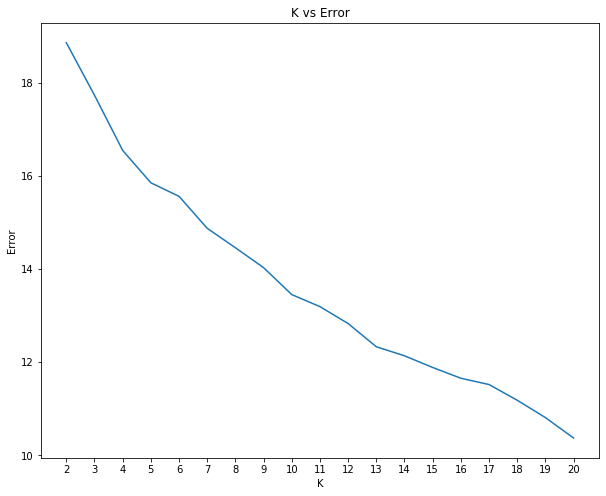

In [25]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

#### 3.5 Cluster Neighborhoods

##### The next step is to cluster neighbrhoods to determine a tour plan for when tourism opens up in the spring. 

In [26]:
#Run k-means to cluster the neighborhood into 7 clusters
kclusters = 7

DC_grouped_clustering = DC_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 1, 3, 3, 3, 2, 3], dtype=int32)

In [27]:
#new dataframe that includes the cluster as well as the top 10 venues for each neighborhood
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

DC_merged = df_DC

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
DC_merged = DC_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how= 'right')

DC_merged.head() # check the last columns!

,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,-76.980348,38.855658,Fort Stanton,1,Intersection,Recreation Center,Park,Museum,Diner,Food & Drink Shop,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market
1,-76.997950,38.841077,Congress Heights,0,Liquor Store,Convenience Store,Fried Chicken Joint,Tennis Court,Road,Intersection,American Restaurant,Ice Cream Shop,Deli / Bodega,Fountain
2,-76.995636,38.830237,Washington Highlands,3,Grocery Store,Asian Restaurant,Basketball Court,Seafood Restaurant,Liquor Store,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
3,-77.009271,38.826952,Bellevue,3,Shoe Repair,Pizza Place,Baseball Field,Playground,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market
4,-76.967660,38.853688,Knox Hill/Buena Vista,2,Liquor Store,Grocery Store,Convenience Store,Pizza Place,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop


## 4. Results

#### 4.1 Map Results

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(DC_merged['Latitude'], DC_merged['Longitude'], DC_merged['Neighborhood'], DC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 4.2 Examine Clusters

##### We will examine each cluster and determine the discriminating venue categories that distinguish each cluster. At this point we will also throw out any clusters that don't fit our need for this study. Then we will use these groups to plan out tourism opportunities in Washington DC. 

#### Cluster 1

In [29]:
DC_merged.loc[DC_merged['Cluster Labels'] == 0, DC_merged.columns[[2] + list(range(3, DC_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Congress Heights,0,Liquor Store,Convenience Store,Fried Chicken Joint,Tennis Court,Road,Intersection,American Restaurant,Ice Cream Shop,Deli / Bodega,Fountain
12,Twining,0,Liquor Store,Restaurant,Pharmacy,Convenience Store,Bike Rental / Bike Share,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
14,Fairlawn,0,Liquor Store,Deli / Bodega,Sandwich Place,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market
46,Shepherd Park,0,Department Store,Theme Park Ride / Attraction,Martial Arts School,Liquor Store,Yoga Studio,Food,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market
67,Gateway,0,Liquor Store,Shipping Store,Construction & Landscaping,Gas Station,Business Service,Thrift / Vintage Store,Fried Chicken Joint,Wine Shop,Dive Bar,Farmers Market
120,NE Boundary,0,Liquor Store,Food,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Yoga Studio


#### Cluster 2

In [30]:
DC_merged.loc[DC_merged['Cluster Labels'] == 1, DC_merged.columns[[2] + list(range(3, DC_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Fort Stanton,1,Intersection,Recreation Center,Park,Museum,Diner,Food & Drink Shop,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market
7,Woodland,1,Recreation Center,Bus Stop,Park,Art Gallery,Museum,Fountain,Food Truck,Frame Store,Food Service,Food Court
25,Fort Totten,1,Memorial Site,Park,Pharmacy,Miscellaneous Shop,Hospital,Grocery Store,Yoga Studio,Fast Food Restaurant,Field,Filipino Restaurant
40,Stronghold,1,Gym,Grocery Store,Lawyer,Park,Tennis Court,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
54,Barnaby Woods,1,Gym / Fitness Center,Field,Park,BBQ Joint,Yoga Studio,Farmers Market,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop
56,Michigan Park,1,Park,Wine Bar,Yoga Studio,Food,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop
68,Langdon,1,Park,Memorial Site,Locksmith,Bus Station,Antique Shop,Dog Run,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop
70,Eckington,1,Train Station,Garden,Park,Check Cashing Service,Yoga Studio,Flea Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
114,Kingman Park,1,Park,Pool,Taco Place,Bus Station,Intersection,Food Truck,Fountain,Frame Store,Food Service,French Restaurant
122,Grant Park,1,Park,Yoga Studio,Food,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop


#### Cluster 3

In [31]:
DC_merged.loc[DC_merged['Cluster Labels'] == 2, DC_merged.columns[[2] + list(range(3, DC_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Knox Hill/Buena Vista,2,Liquor Store,Grocery Store,Convenience Store,Pizza Place,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
5,Shipley,2,Convenience Store,Dance Studio,Chinese Restaurant,Performing Arts Venue,Liquor Store,Wings Joint,Fountain,Food Truck,Food Service,Frame Store
8,Garfield Heights,2,Park,Chinese Restaurant,Bus Stop,Art Gallery,Convenience Store,Yoga Studio,Food,Filipino Restaurant,Fish & Chips Shop,Flea Market
11,Dupont Park,2,Liquor Store,Convenience Store,Pharmacy,Seafood Restaurant,Mobile Phone Shop,Bike Rental / Bike Share,Restaurant,Gym / Fitness Center,Bank,Sandwich Place
15,Penn Branch,2,Boat or Ferry,Wings Joint,Bike Rental / Bike Share,Convenience Store,Laundromat,Yoga Studio,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market
26,Pleasant Hill,2,Dance Studio,Chinese Restaurant,Convenience Store,Sandwich Place,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market
34,Naylor Gardens,2,Convenience Store,Liquor Store,Gym,Sandwich Place,Wings Joint,Shoe Store,Grocery Store,Cosmetics Shop,Playground,Coffee Shop
37,Benning Ridge,2,Shipping Store,Insurance Office,Burger Joint,Convenience Store,Food,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market
51,Manor Park,2,Rental Car Location,Baseball Field,Convenience Store,Caribbean Restaurant,Food,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop
55,Queens Chapel,2,Liquor Store,Residential Building (Apartment / Condo),Chinese Restaurant,Convenience Store,Gym / Fitness Center,Flea Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field


#### Cluster 4

In [32]:
DC_merged.loc[DC_merged['Cluster Labels'] == 3, DC_merged.columns[[2] + list(range(3, DC_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Highlands,3,Grocery Store,Asian Restaurant,Basketball Court,Seafood Restaurant,Liquor Store,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
3,Bellevue,3,Shoe Repair,Pizza Place,Baseball Field,Playground,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market
6,Douglass,3,Bank,Video Store,Breakfast Spot,Spa,Cosmetics Shop,Pizza Place,Sandwich Place,Flower Shop,Fast Food Restaurant,Field
9,Near Southeast,3,Gym / Fitness Center,Sushi Restaurant,Coffee Shop,Park,Pizza Place,Burger Joint,Brewery,New American Restaurant,Supermarket,Clothing Store
10,Capitol Hill,3,Food Truck,Bar,Italian Restaurant,Park,Deli / Bodega,Bike Rental / Bike Share,Coffee Shop,American Restaurant,Pizza Place,Spa
13,Randle Highlands,3,Intersection,Seafood Restaurant,Bank,Sandwich Place,Gym / Fitness Center,Fish & Chips Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
16,Barry Farm,3,Bus Stop,Intersection,Basketball Court,Metro Station,Rental Car Location,Antique Shop,Furniture / Home Store,Field,Filipino Restaurant,Fish & Chips Shop
17,Historic Anacostia,3,American Restaurant,Diner,History Museum,Boutique,Outdoor Sculpture,Fast Food Restaurant,Grocery Store,Coffee Shop,Sandwich Place,Comfort Food Restaurant
18,Columbia Heights,3,Pizza Place,Bar,Gym,Bakery,Mediterranean Restaurant,Filipino Restaurant,Pharmacy,South American Restaurant,Soccer Field,Mexican Restaurant
19,Logan Circle/Shaw,3,Dive Bar,Wine Bar,Bar,Mexican Restaurant,Coffee Shop,Gym / Fitness Center,American Restaurant,Public Art,Cantonese Restaurant,Thai Restaurant


#### Cluster 5

In [33]:
DC_merged.loc[DC_merged['Cluster Labels'] == 4, DC_merged.columns[[2] + list(range(3, DC_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Greenway,4,Tennis Court,Yoga Studio,Food,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop
95,Spring Valley,4,Tennis Court,Athletics & Sports,Yoga Studio,Falafel Restaurant,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop


#### Cluster 6

In [34]:
DC_merged.loc[DC_merged['Cluster Labels'] == 5, DC_merged.columns[[2] + list(range(3, DC_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
115,Hill East,5,Bakery,Pizza Place,Yoga Studio,Falafel Restaurant,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop


#### Cluster 7

In [35]:
DC_merged.loc[DC_merged['Cluster Labels'] == 6, DC_merged.columns[[2] + list(range(3, DC_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
117,Mayfair,6,Cosmetics Shop,Soccer Field,Yoga Studio,Food,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop


## 5. Discussion

##### Looking at the results the first thing we need to do is to exclude clusters that aren’t good for tourism. Clusters 1, 3, 5, and 7 would be the first ones I would exclude from tourism opportunities. The cluster 1 venues are dominated by liquor stores and convenience stores, the cluster 3 venues is also dominated by convenience stores. The cluster 5 venues are a majority sporting and gym locations. Finally cluster 7 is a mix of liquor stores and gyms. 
##### This leaves us with clusters 2, 4, and 6. Cluster 2 is dominated by parks which can be used for more natural tours. The venues for clusters 4 and 6 are museums and restaurants which would be the best for tourism opportunities. 


## 6. Conclusion

##### In conclusion, we looked at venue data using data science and machine learning techniques, using knowledge gained throughout the coursework. We took a business problem and looked at ways to solve it using data science, and presented those findings. 

##### An area that I could have improved upon this project would have been digging deep into demographics data, population, income, age, etc to give a more detailed answer to the business problem. 
